In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import imageio.v2 as imageio
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
display(device)

device(type='cuda')

In [3]:
np.random.seed(45)
num_samples = 40

# Generate data
x1 = np.random.uniform(-1, 1, num_samples)
f_x = 3*x1 + 4
eps = np.random.randn(num_samples)
y = f_x + eps

In [4]:
theta = torch.tensor([1., 1.], requires_grad=True, dtype=torch.float64)

In [5]:
x_tensor = torch.tensor(x1, dtype=torch.float64).reshape(-1, 1)
X = torch.cat((torch.ones(x_tensor.shape), x_tensor), 1)
y = torch.tensor(y, dtype=torch.float64).reshape(-1, 1)

def true_gradient():
    y_pred = (X @ theta).reshape(-1, 1)
    loss = torch.mean((y_pred - y) ** 2, dtype=torch.float64)
    loss.backward()
    true_grad = theta.grad.clone()
    true_loss = loss.data.clone()
    return true_grad, true_loss

true_grad, true_loss = true_gradient()
display(true_grad, true_loss, theta)

tensor([-5.6164, -0.5630], dtype=torch.float64)

tensor(9.3556, dtype=torch.float64)

tensor([1., 1.], dtype=torch.float64, requires_grad=True)

In [6]:
opt_theta = None

def compute_loss_analytical(X=X, y=y, theta_opt=None):
    x_tensor = X.clone().detach()
    y_tensor = y.clone().detach()
    if theta_opt is None:
        theta_opt = torch.inverse(x_tensor.T @ x_tensor) @ x_tensor.T @ y_tensor
	
    y_pred_tensor = (x_tensor @ theta_opt).reshape(-1, 1)
    loss_opt = torch.mean((y_pred_tensor - y_tensor) ** 2, dtype=torch.float64)
    return loss_opt.item()

loss_opt = compute_loss_analytical()
display(loss_opt)

0.5957541565733318

In [7]:
x_tensor = X.clone().detach()
y_tensor = y.clone().detach()
opt_theta = torch.inverse(x_tensor.T @ x_tensor) @ x_tensor.T @ y_tensor

In [8]:
def compute_sgd(x_i, y_i):
    theta.grad.zero_()
    y_pred_i = x_i @ theta
    loss_i = torch.mean((y_pred_i - y_i) ** 2, dtype=torch.float64)
    loss_i.backward()
    
    return theta.grad.clone()

stochastic_grads = []

for i in range(y.shape[0]):
    x_i = X[i].clone().detach()
    y_i = y[i].clone().detach()
    stochastic_grads.append(compute_sgd(x_i, y_i))

mean_stochastic_grad = torch.mean(torch.stack(stochastic_grads), dim=0)

display(mean_stochastic_grad)

tensor([-5.6164, -0.5630], dtype=torch.float64)

In [9]:
residual_tensor = true_grad - mean_stochastic_grad
display(residual_tensor)

tensor([-8.8818e-16, -1.1102e-16], dtype=torch.float64)

In [10]:
def get_loss(theta_given):
    y_pred = (X @ theta_given).reshape(-1, 1)
    loss = torch.mean((y_pred - y) ** 2, dtype=torch.float64)
    return loss.item()

As we can observe from the above cell, the values in the residual tensor are all of the order $10^{-16}$, which indicates that the error is minimal. We can conclude that the stochastic gradient is a good estimate of the true gradient.

In [11]:
pretty_print = {'bgd': 'Batch Gradient Descent', 'mbgd': 'Mini-Batch Gradient Descent', 'sgd': 'Stochastic Gradient Descent'}

def gradient_descent(grad_type: str='bgd', epochs=1000, eps=1e-3, alpha=5e-2, minibatch_size=4, momentum=None):
    loss_vals = []
    theta_vals = []
    theta_copy = torch.randn(theta.shape, requires_grad=True, dtype=torch.float64)
    theta_copy.requires_grad = True
    epoch = 1
    latest_loss = 0
    change = torch.zeros(theta_copy.shape)
    iterations = 0
    while epoch <= epochs:
        epoch_loss = None
        if grad_type == 'bgd':
            y_pred = (X @ theta_copy).reshape(-1, 1)
            loss = torch.mean((y_pred - y) ** 2, dtype=torch.float64)
            loss.backward()
            # latest_loss = loss.item()

            with torch.no_grad():
                if momentum is not None:
                    new_change = alpha * theta_copy.grad + momentum * change
                    theta_copy -= new_change
                    change = new_change
                else:
                    theta_copy -= alpha * theta_copy.grad

            theta_copy.grad.zero_()

            y_pred_all = (X @ theta_copy).reshape(-1, 1)
            latest_loss = torch.mean((y_pred_all - y) ** 2, dtype=torch.float64).item()
            epoch_loss = latest_loss
            iterations += num_samples
        
        elif grad_type == 'mbgd':
            random_permutation = torch.randperm(num_samples)
            X_shuffled = X[random_permutation].clone().detach()
            y_shuffled = y[random_permutation].clone().detach()
            minibatch_losses = []

            for i in range(0, num_samples, minibatch_size):
                X_batch = X_shuffled[i:i + minibatch_size].clone().detach()
                y_batch = y_shuffled[i:i + minibatch_size].clone().detach()
                y_pred = (X_batch @ theta_copy).reshape(-1, 1)
                
                loss = torch.mean((y_pred - y_batch) ** 2, dtype=torch.float64)
                loss.backward()
                minibatch_losses.append(loss.item())
                # latest_loss = loss.item()

                with torch.no_grad():
                    if momentum is not None:
                        new_change = alpha * theta_copy.grad + momentum * change
                        theta_copy -= new_change
                        change = new_change
                    else:
                        theta_copy -= alpha * theta_copy.grad

                theta_copy.grad.zero_()
                iterations += minibatch_size

            y_pred_all = (X @ theta_copy).reshape(-1, 1)
            latest_loss = torch.mean((y_pred_all - y) ** 2, dtype=torch.float64).item()
            epoch_loss = np.mean(minibatch_losses)

        else:
            random_permutation = torch.randperm(num_samples)
            X_shuffled = X[random_permutation].clone().detach()
            y_shuffled = y[random_permutation].clone().detach()
            stochastic_losses = []

            for i in range(num_samples):
                X_i = X_shuffled[i].clone().detach()
                y_i = y_shuffled[i].clone().detach()
                y_pred = (X_i @ theta_copy)

                loss = torch.mean((y_pred - y_i) ** 2, dtype=torch.float64)
                loss.backward()
                stochastic_losses.append(loss.item())

                with torch.no_grad():
                    if momentum is not None:
                        new_change = alpha * theta_copy.grad + momentum * change
                        theta_copy -= new_change
                        change = new_change
                    else:
                        theta_copy -= alpha * theta_copy.grad

                theta_copy.grad.zero_()

            y_pred_all = (X @ theta_copy).reshape(-1, 1)
            latest_loss = torch.mean((y_pred_all - y) ** 2).item()
            epoch_loss = np.mean(stochastic_losses)
            iterations += num_samples

        loss_vals.append(epoch_loss)
        theta_vals.append(theta_copy.clone())

        if torch.norm(theta_copy.squeeze() - opt_theta.squeeze()) <= eps:
            # print(f'{pretty_print[grad_type]} converged in {epoch} epochs')
            return loss_vals, theta_vals, iterations, epoch

        epoch += 1
    return loss_vals, theta_vals, iterations, epoch

In [12]:
def plot_loss_vs_epochs(momentum=None):
    iters_per_class = {}
    
    for grad_type in ['bgd', 'mbgd', 'sgd']:
        losses, thetas, iters, epoch = gradient_descent(grad_type=grad_type, momentum=None)
        iters_per_class[pretty_print[grad_type]] = iters
        epochs = np.arange(1, len(losses) + 1, dtype=np.int32)
        display(pretty_print[grad_type], np.min(losses))
        plt.plot(epochs[:15], losses[:15], marker='.')
        plt.grid(visible=True)
        plt.title(f'Loss vs. Epochs for {pretty_print[grad_type]}')
        plt.xlim(left=1, right=15)
        plt.ylim(bottom=0, top=30)
        plt.hlines(loss_opt, 0, len(epochs), linestyles='--', colors='red')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()

    plt.bar(['Batch', 'Mini-Batch', 'Stochastic'], iters_per_class.values())
    plt.title(f'(Yet to be) Average Iterations Per Method {"With" if momentum else "Without"} Momentum')
    plt.xlabel('Method of Gradient Descent')
    plt.ylabel('Number of Iterations')
    plt.show()

'Batch Gradient Descent'

0.5957544515289145

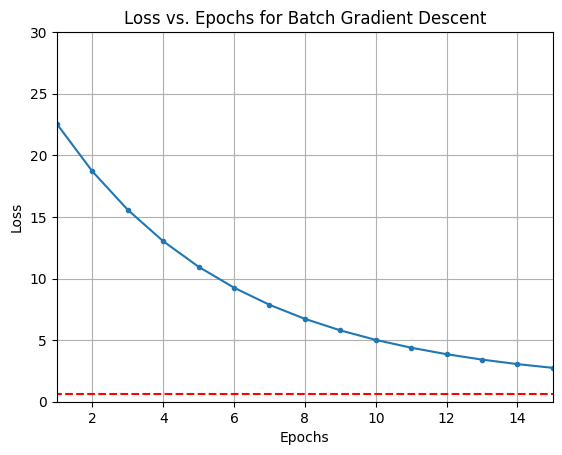

'Mini-Batch Gradient Descent'

0.599521263575778

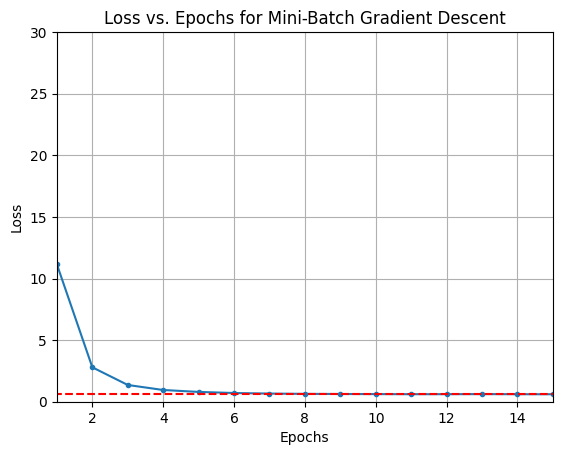

'Stochastic Gradient Descent'

0.528518145692181

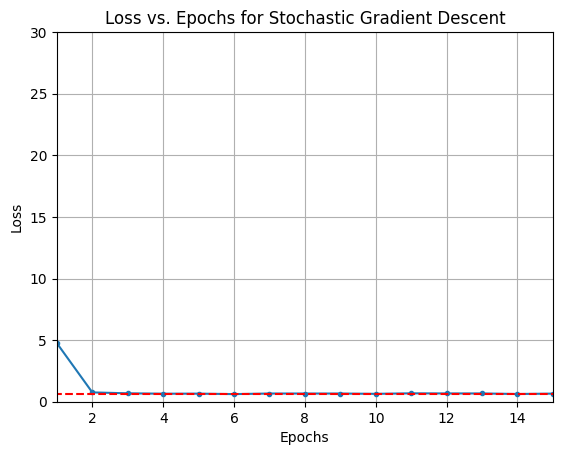

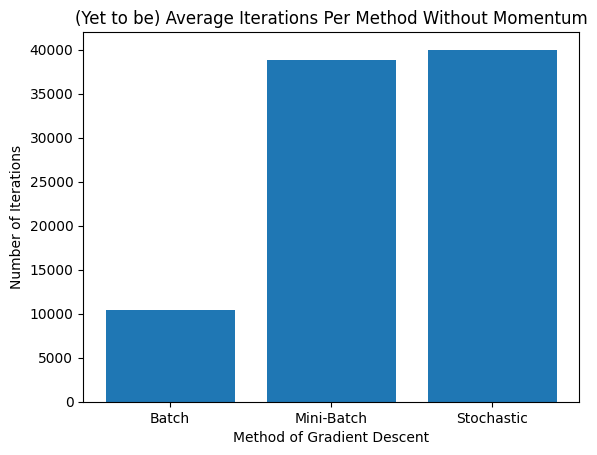

In [13]:
plot_loss_vs_epochs(momentum=None)

'Batch Gradient Descent'

0.5957544572261199

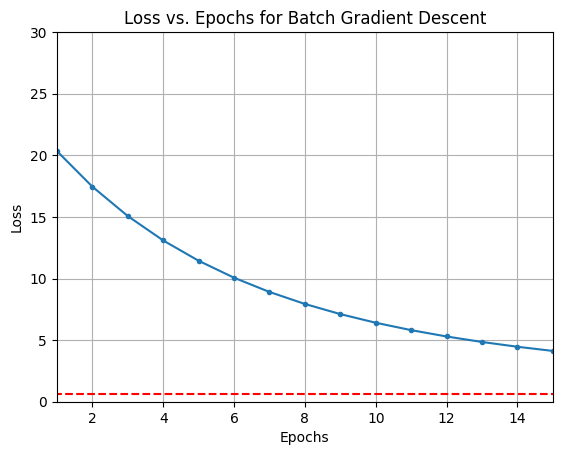

'Mini-Batch Gradient Descent'

0.6027321560740574

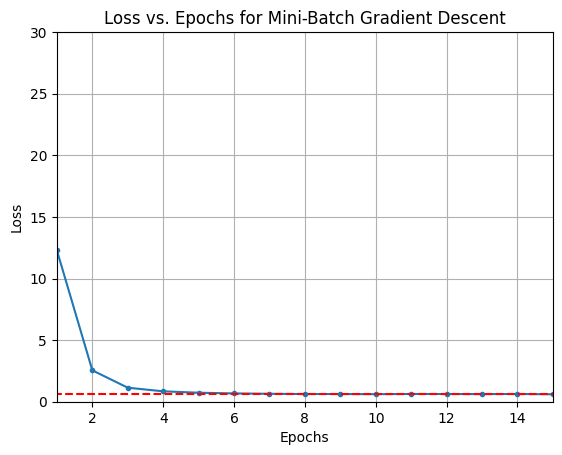

'Stochastic Gradient Descent'

0.5766608227693977

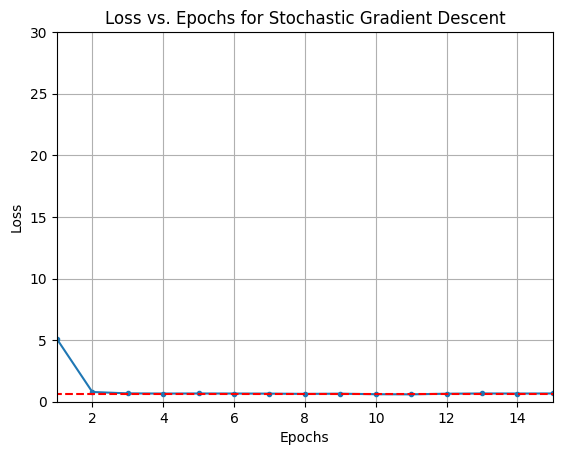

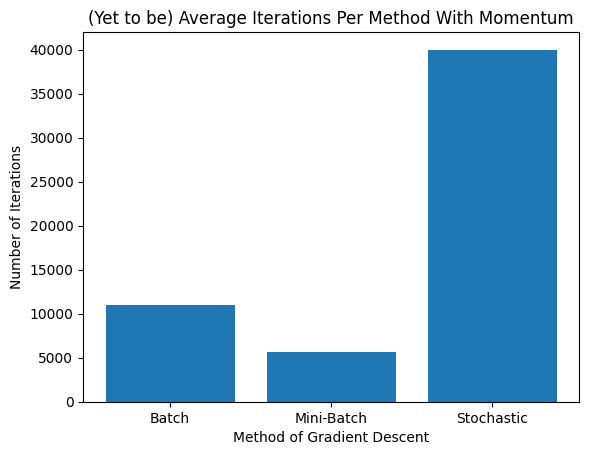

In [14]:
plot_loss_vs_epochs(momentum=0.9)

In [15]:
theta0_vals = np.linspace(-5, 5, 100)
theta1_vals = np.linspace(-5, 5, 100)
theta0_grid, theta1_grid = np.meshgrid(theta0_vals, theta1_vals)

loss_grid = np.zeros_like(theta0_grid)
for i in range(len(theta0_vals)):
    for j in range(len(theta1_vals)):
        theta_temp = torch.tensor([theta0_vals[i], theta1_vals[j]], dtype=torch.float64)
        loss_grid[j, i] = compute_loss_analytical(X, y, theta_temp)

def plot_contour_with_trajectory(theta_vals, step_num, frames_dir, save_frames=True):
    fig, ax = plt.subplots()
    
    contour = ax.contour(theta0_grid, theta1_grid, loss_grid, levels=np.logspace(-1, 2, 20), cmap='coolwarm')
    ax.set_xlabel(r'$\theta_0$')
    ax.set_ylabel(r'$\theta_1$')
    ax.set_title('Loss Contour Plot with Gradient Descent Path')
    fig.colorbar(contour, ax=ax)

    theta_vals_np = np.array([theta.detach().numpy() for theta in theta_vals])
    ax.quiver(theta_vals_np[:-1, 0], theta_vals_np[:-1, 1],
              theta_vals_np[1:, 0] - theta_vals_np[:-1, 0],
              theta_vals_np[1:, 1] - theta_vals_np[:-1, 1],
              angles='xy', scale_units='xy', scale=1, color='r', label='Gradient Descent Path')

    ax.scatter(theta_vals_np[0, 0], theta_vals_np[0, 1], color='blue', marker='o', label='Start')
    
    ax.legend()

    if save_frames:
        frame_path = os.path.join(frames_dir, f'frame_{step_num:05d}.png')
        plt.savefig(frame_path)
    
    plt.close(fig)

def create_gif_from_frames(output_gif, frames_dir, duration=1):
    frame_paths = [os.path.join(frames_dir, frame) for frame in sorted(os.listdir(frames_dir)) if frame.endswith('.png')]
    
    frames = [imageio.imread(frame) for frame in frame_paths]
    imageio.mimsave(output_gif, frames, duration=duration)
    print(f"GIF saved as {output_gif}")

def clear_frames_dir(frames_dir):
    for file in os.listdir(frames_dir):
        file_path = os.path.join(frames_dir, file)
        if os.path.isfile(file_path):
            os.unlink(file_path)

for momentum in [None, 0.5]:
    momentum_label = 'momentum_0.5' if momentum is not None else 'no_momentum'
    for grad_type in ['bgd', 'mbgd', 'sgd']:
        grad_label = grad_type.upper()
        
        frames_dir = f'frames_{grad_label}_{momentum_label}/'
        os.makedirs(frames_dir, exist_ok=True)
        
        loss_vals, theta_vals, _, epoch = gradient_descent(grad_type=grad_type, momentum=momentum)
        for step_num, theta in enumerate(theta_vals):
            if step_num % 75 == 0:
                plot_contour_with_trajectory(theta_vals[:step_num+1], step_num, frames_dir)

        output_gif_path = f'gradient_descent_{grad_label}_{momentum_label}.gif'
        create_gif_from_frames(output_gif_path, frames_dir)

        clear_frames_dir(frames_dir)

GIF saved as gradient_descent_BGD_no_momentum.gif
GIF saved as gradient_descent_MBGD_no_momentum.gif
GIF saved as gradient_descent_SGD_no_momentum.gif
GIF saved as gradient_descent_BGD_momentum_0.5.gif
GIF saved as gradient_descent_MBGD_momentum_0.5.gif
GIF saved as gradient_descent_SGD_momentum_0.5.gif


In [16]:
iters_per_class = {}
epochs_per_class = {}

for i in range(10):
    for grad_type in ['bgd', 'mbgd', 'sgd']:
        losses, thetas, iters, epoch = gradient_descent(grad_type=grad_type, momentum=None)
        if pretty_print[grad_type] not in iters_per_class:
            iters_per_class[pretty_print[grad_type]] = [iters]
        else:
            iters_per_class[pretty_print[grad_type]].append(iters)
        
        if pretty_print[grad_type] not in epochs_per_class:
            epochs_per_class[pretty_print[grad_type]] = [epoch]
        else:
            epochs_per_class[pretty_print[grad_type]].append(epoch)

        epochs = np.arange(1, len(losses) + 1, dtype=np.int32)

for cls in iters_per_class:
    iters_per_class[cls] = np.mean(iters_per_class[cls])

for cls in epochs_per_class:
    epochs_per_class[cls] = np.mean(epochs_per_class[cls])

print(iters_per_class)
print(epochs_per_class)

{'Batch Gradient Descent': 10540.0, 'Mini-Batch Gradient Descent': 15248.0, 'Stochastic Gradient Descent': 39876.0}
{'Batch Gradient Descent': 263.5, 'Mini-Batch Gradient Descent': 381.3, 'Stochastic Gradient Descent': 997.8}


In [17]:
iters_per_class = {}
epochs_per_class = {}

for i in range(10):
    for grad_type in ['bgd', 'mbgd', 'sgd']:
        losses, thetas, iters, epoch = gradient_descent(grad_type=grad_type, momentum=0.5)
        if pretty_print[grad_type] not in iters_per_class:
            iters_per_class[pretty_print[grad_type]] = [iters]
        else:
            iters_per_class[pretty_print[grad_type]].append(iters)
        
        if pretty_print[grad_type] not in epochs_per_class:
            epochs_per_class[pretty_print[grad_type]] = [epoch]
        else:
            epochs_per_class[pretty_print[grad_type]].append(epoch)

        epochs = np.arange(1, len(losses) + 1, dtype=np.int32)

for cls in iters_per_class:
    iters_per_class[cls] = np.mean(iters_per_class[cls])

for cls in epochs_per_class:
    epochs_per_class[cls] = np.mean(epochs_per_class[cls])

print(iters_per_class)
print(epochs_per_class)

{'Batch Gradient Descent': 4788.0, 'Mini-Batch Gradient Descent': 28140.0, 'Stochastic Gradient Descent': 40000.0}
{'Batch Gradient Descent': 119.7, 'Mini-Batch Gradient Descent': 704.1, 'Stochastic Gradient Descent': 1001.0}
